
# kaggleのデータセットを用いてモデルを構築する

### 目的：100kmあたりのガソリン消費量を予測する
###  URL:https://www.kaggle.com/anderas/car-consume

・利用するデータ「measurements.csv」（データ数：388行12列）

| 列 | 項目 | 項目名 | 欠損有無 | 利用有無 |
| :--- | :--- | :--- | :---: | :---: |
|  1 | distance | 走行していたキロメートル単位の距離 | - | ○ |
|  2 | consume | ディスプレイに表示される100キロメートルあたりのリットル単位の消費 | - | ○ |
|  3 | speed | 平均速度 | - | ○ |
|  4 | temp_inside | 加熱の設定 | 欠損あり | × |
|  5 | temp_outside | 外気温度 | - | ○ |
|  6 | specials | 雨または雪、気候変動が発生している場合（「AC」） | 欠損あり | × |
|  7 | gas_type | ガソリンの種類 | - | ○ |
|  8 | AC | ホットエンコードされた特別な「AC」 | - | ○ |
|  9 | rain | 雨/雪 | - | ○ |
| 10 | sun | 晴れ | - | ○ |
| 11 | refill liters | リフィルリッター | 欠損あり | × |
| 12 | refill gas| リフィルガス | 欠損あり | × |

In [20]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix,precision_recall_fscore_support
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数

# 警告非表示
import warnings
warnings.filterwarnings('ignore')

In [21]:
# データセット読込
#df= pd.read_csv('./measurements.csv')
df = pd.read_excel("./measurements2.xlsx")

# 欠損項目および不要項目を削除
df = df.drop(['specials','refill liters','refill gas'], axis=1)

# 欠損値の補完
df['temp_inside'] = df['temp_inside'].fillna(df['temp_inside'].median()) # 中央値

#print("\n▼ 欠損項目を確認")
#print(df.isnull().sum())

# ダミー変換
df = pd.get_dummies(df, columns=['gas_type'])

# データを標準化
scaler = StandardScaler()        
df['temp_inside'] = scaler.fit_transform(df.loc[:, ['temp_inside']])
df['temp_outside'] = scaler.fit_transform(df.loc[:, ['temp_outside']])
df['distance'] = scaler.fit_transform(df.loc[:, ['distance']])
df['speed'] = scaler.fit_transform(df.loc[:, ['speed']])


# データ並び替え
df = df.ix[:,[1,0,2,3,4,5,6,7,8,9]]

df.index.name="id"

print("\n▼ csvデータ確認")
display(df.head())

print("\n▼ 統計量確認")
#df.describe()
print(df.info())



▼ csvデータ確認


,consume,distance,speed,temp_inside,temp_outside,AC,rain,sun,gas_type_E10,gas_type_SP98
id,,,,,,,,,,
0,5.0,0.368714,-1.172804,-0.434544,0.091908,0,0,0,1,0
1,4.2,-0.338044,-0.878274,-0.434544,0.235123,0,0,0,1,0
2,5.5,-0.373381,-0.289216,-0.434544,0.521552,0,0,0,1,0
3,3.9,-0.298288,-0.436480,-0.434544,0.378338,0,0,0,1,0
4,4.5,-0.050923,0.299843,-0.434544,0.521552,0,0,0,1,0



▼ 統計量確認
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 10 columns):
consume          388 non-null float64
distance         388 non-null float64
speed            388 non-null float64
temp_inside      388 non-null float64
temp_outside     388 non-null float64
AC               388 non-null int64
rain             388 non-null int64
sun              388 non-null int64
gas_type_E10     388 non-null uint8
gas_type_SP98    388 non-null uint8
dtypes: float64(5), int64(3), uint8(2)
memory usage: 25.1 KB
None


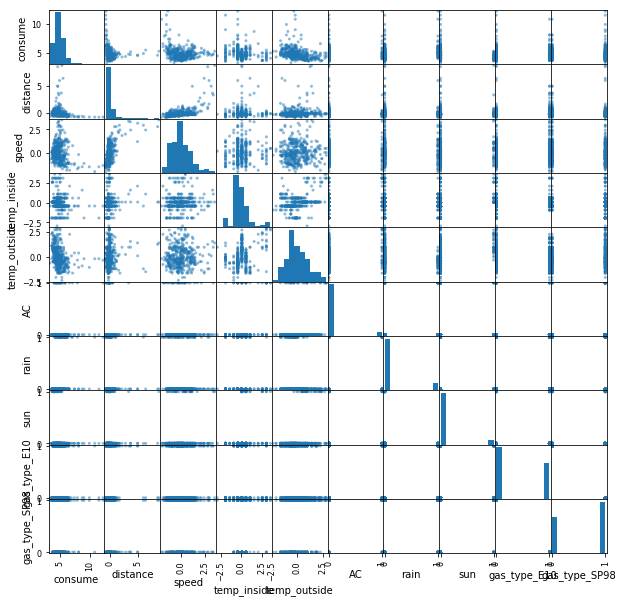

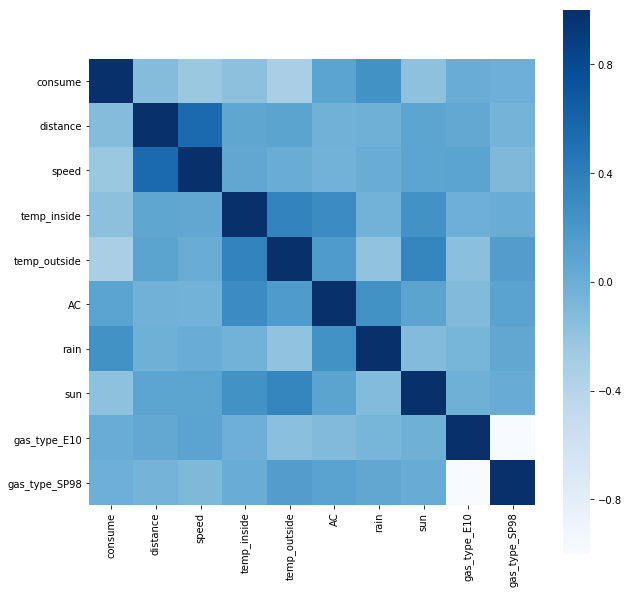

In [22]:
# 散布図行列を書いてみる
pd.plotting.scatter_matrix(df, figsize=(10,10))
plt.show()

# 相関係数をヒートマップにして可視化
df.corr()
plt.figure(figsize=(10, 10)) 
sns.heatmap(df.corr(), square=True, cmap='Blues')
plt.show()


In [23]:
# 係数を求める
y = df["consume"].values
X = df.drop('consume', axis=1).values

# 線形回帰モデル生成
regr = LinearRegression(fit_intercept=True)

# 学習
regr.fit(X, y)

# リスト型へ変換
n_features = list(df.drop('consume', axis=1).columns)
fti = regr.coef_.tolist()

print("\n▼ 各重みを表示")
print('w0 = {:.3f}'.format(regr.intercept_))
for i, feature in enumerate(n_features):
    print(feature.ljust(30, ' ') + "---->   w{:.0f} = {:.3f}".format(i + 1, fti[i]))
    #print('\t{0:30s} : {1:>.6f}'.format(feature, fti[i]))


▼ 各重みを表示
w0 = 4.826
distance                      ---->   w1 = 0.045
speed                         ---->   w2 = -0.248
temp_inside                   ---->   w3 = -0.077
temp_outside                  ---->   w4 = -0.277
AC                            ---->   w5 = 0.468
rain                          ---->   w6 = 0.521
sun                           ---->   w7 = -0.131
gas_type_E10                  ---->   w8 = 0.018
gas_type_SP98                 ---->   w9 = -0.018


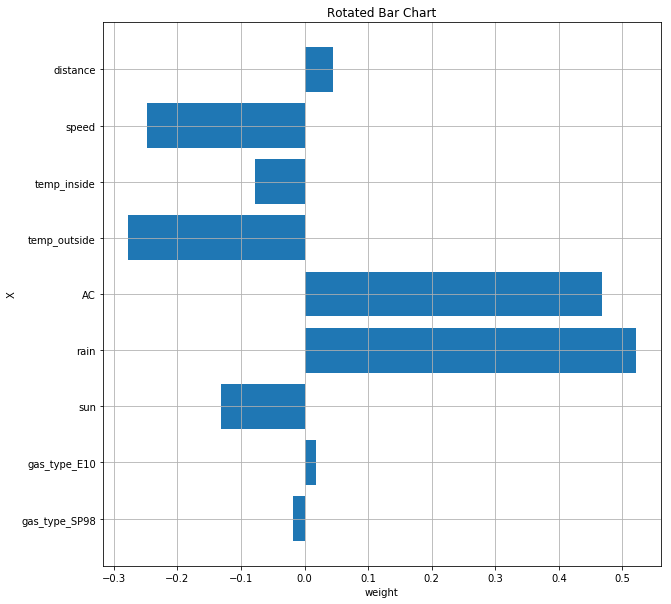

In [24]:
# グラフ化  
plt.figure(figsize=(10, 10))
plt.barh(np.arange(len(n_features))[::-1], fti, align='center')
plt.yticks(np.arange(len(n_features))[::-1], n_features)
plt.title('Rotated Bar Chart')
plt.xlabel('weight')
plt.ylabel('X')
plt.grid()
plt.show()

In [27]:
# 目的変数を予測
y_pred = regr.predict(X) # 関数を使用する

# 二乗誤差
squared_error2 = 0.5 * np.sum((y - y_pred) ** 2)
print('二乗誤差 = {:.3f}'.format(squared_error2))

# MSEを計算
mse = mean_squared_error(y, y_pred) 
print("MSE = %s"%round(mse,3) )  

# MAEを計算
mae = mean_absolute_error(y, y_pred) 
print("MAE = %s"%round(mae,3) )

# RMSEを計算
rmse = np.sqrt(mse)
print("RMSE = %s"%round(rmse, 3) )

二乗誤差 = 163.903
MSE = 0.845
MAE = 0.618
RMSE = 0.919
